# Vehicle Classifier #

Creating the Linear Support Vector Machine that will be used for vehicle detection

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from plot_images import *
from vehicle_features import *

## Preparing the Training Data ##

The training data features are in the following order:
1. HOG
2. Color binning
3. Color histogram

In [2]:
def getTrainingImages(pathname):
    files = glob.glob(pathname)
    images = []
    for fname in files:
        img = mpimg.imread(fname)
        images.append(img)
    return images

#Not Cars
nots = getTrainingImages('training_images/non-vehicles/Extras/*.png')
nots = nots+getTrainingImages('training_images/non-vehicles/GTI/*.png')
print("{} not-car training images".format(len(nots)))

#Cars
cars = getTrainingImages('training_images/vehicles/GTI_Far/*.png')
cars = cars+getTrainingImages('training_images/vehicles/GTI_Left/*.png')
cars = cars+getTrainingImages('training_images/vehicles/GTI_MiddleClose/*.png')
cars = cars+getTrainingImages('training_images/vehicles/GTI_Right/*.png')
cars = cars+getTrainingImages('training_images/vehicles/KITTI_extracted/*.png')
print("{} car training images".format(len(cars)))

8968 not-car training images
8792 car training images


In [8]:
def extractImgFeatures(img, color_space_in, hog_orient, hog_pix_per_cell, 
                       hog_cells_per_block, spatial_size, hist_bins, 
                       vis, hog_channel):
    # Extract the features from the image
    img_features = []
    imgC = convertColorSpace(img, color_space_in)

    # First the HOG
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(imgC.shape[2]):
            hog = extractHog(imgC[:,:,channel], hog_orient, hog_pix_per_cell, 
                             hog_cells_per_block, vis=False, feature_vec=True)
            hog_features.append(hog)
        hog_features = np.ravel(hog_features)
    else:
        if vis == True:
            hog_features, hog_image = extractHog(imgC[:,:,hog_channel], hog_orient, 
                                                 hog_pix_per_cell, hog_cells_per_block,
                                                 vis=True, feature_vec=True)
        else:
            hog_features = extractHog(imgC[:,:,hog_channel], hog_orient, 
                                                 hog_pix_per_cell, hog_cells_per_block,
                                                 vis=False, feature_vec=True)
    img_features.append(hog_features)

    # Second the color binning
    spatial_features = binColorsSpatially(imgC, spatial_size)
    img_features.append(spatial_features)

    # Third the color histogram
    hist_features = computeColorHistogram(imgC, hist_bins)
    img_features.append(hist_features)

    # Concatenate features and return
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)
    
def extractFeatures(imgs, color_space_in, hog_orient, hog_pix_per_cell, 
                    hog_cells_per_block, spatial_size, hist_bins):
    # Extract features from a list of images
    features = []
    for img in imgs:
        img_features = extractImgFeatures(img, color_space_in, 
                                          hog_orient, hog_pix_per_cell, hog_cells_per_block,
                                          spatial_size, hist_bins, 
                                          vis=False, hog_channel='ALL')
        
        # Concatenate features and append to the imgs' list
        features.append(img_features)
    return features


In [9]:
color_space_in = 'RGB'
hog_orient = 9 
hog_pix_per_cell = 8 
hog_cells_per_block = 2 
spatial_size = (8, 8)
hist_bins = 40

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


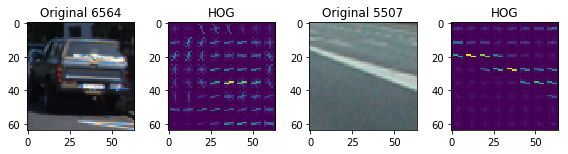

In [14]:
car_idx = np.random.randint(0, len(cars))
not_idx = np.random.randint(0, len(nots))

car_features, car_hog = extractImgFeatures(cars[car_idx], color_space_in, hog_orient, 
                                           hog_pix_per_cell, hog_cells_per_block, 
                                           spatial_size, hist_bins, vis=True, hog_channel=0)
not_features, not_hog = extractImgFeatures(nots[not_idx], color_space_in, hog_orient, 
                                           hog_pix_per_cell, hog_cells_per_block, 
                                           spatial_size, hist_bins, vis=True, hog_channel=0)

plotMany(1,4, [cars[car_idx], car_hog, nots[not_idx], not_hog],
         ["Original {}".format(car_idx),'HOG',"Original {}".format(not_idx), 'HOG'], 
         [None,None,None,None])

In [15]:
#Extract the features
notcar_features = extractFeatures(nots, color_space_in, hog_orient, 
                                  hog_pix_per_cell, hog_cells_per_block, 
                                  spatial_size, hist_bins)
car_features = extractFeatures(cars, color_space_in, hog_orient, 
                               hog_pix_per_cell, hog_cells_per_block, 
                               spatial_size, hist_bins)

# Column scaling for X
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Y Labels (1 = car, 0 = notcar)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, 
                                                    test_size=0.1, 
                                                    random_state=rand_state)

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


## Training the SVC ##

In [21]:
svc = LinearSVC()

# training with a "stopwatch" running
t=time.time()
svc.fit(X_train, y_train)

print('Training classifier:')
print("\t* {} feature vectors".format(len(X_train[0])))
print("\t* Duration {:.4f} seconds".format(time.time()-t))
print("\t* Accuracy of {:.4f}".format(svc.score(X_test, y_test)))

Training classifier:
	* 5604 feature vectors
	* duration 11.5396 seconds
Test Accuracy of 0.9904
